In [184]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.cm as cm
import scipy.misc
from PIL import Image
import scipy.io
import os
import cv2
import math
import scipy
import scipy.ndimage.interpolation as sni
import skimage.color as color

# Make sure that caffe is on the python path:
caffe_root = '../'  
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
caffe.set_mode_gpu()
caffe.set_device(0)

In [185]:
# load pretrain caffe model for inference
net = caffe.Net( '../SUNRGBD/deploy.prototxt', '../SUNRGBD/model2/model_iter_80000.caffemodel', caffe.TEST)
# net = caffe.Net( '../SUNRGBD/deploy.prototxt', '../SUNRGBD/SUNRGBD_final.caffemodel', caffe.TEST)

In [186]:
# crop image to 426*426*3 using central crop
def img_middle_crop(image):
    start_h = np.uint8((image.shape[0] - 426) / 2)
    start_w = np.uint8((image.shape[1] - 426) / 2)
    end_h = start_h + 426
    end_w = start_w + 426
    croped_img = image[start_h:end_h, start_w:end_w]
    return croped_img

In [187]:
import matplotlib.pyplot as plt
def prepare_blob(image_name, hha_name):
     # read image and hha data
    image_blob = caffe.io.load_image(image_name)*255.
    hha_blob = caffe.io.load_image(hha_name)*255.
    
    # crop image
    #image_blob = img_middle_crop(image_blob)
   # hha_blob = img_middle_crop(hha_blob)
#     image_blob=image_resize(image_blob)
#     hha_blob=image_resize(hha_blob)
    
    image_blob = image_blob[:,:,::-1]                 # convert from RGB to BGR
    
    #subtract the mean of BGR
    image_blob -= np.array((91.246,96.291,115.668))
    #image_blob -= 110.324
    image_blob = np.transpose(image_blob, [2, 0, 1])     # permute width and height
    
    hha_blob = hha_blob[:, :, ::-1]                  # convert from HHA to AHH
    #subtract the mean of AHH
    hha_blob -= np.array((112.737,227.408,17.409))
    #hha_blob -= 115.042
    hha_blob = np.transpose(hha_blob, [2, 0, 1])         # permute width and height
    
    return image_blob, hha_blob

In [188]:
# Make sure gt, output using the same colormap
def myimagesc(image, mapping):
    new_image = np.zeros((image.shape[0], image.shape[1], 3), dtype="float32")
    for i in xrange(image.shape[0]):
        for j in xrange(image.shape[1]):
            index = image[i,j]
            new_image[i,j,:] = mapping[index]*256 #mapping.txt文件里存储的就是256种特定的、具有语义的颜色

    new_image = new_image*1.0
    return new_image

In [189]:
# Run one example for demo
# image_name = 'images/bedroom.jpg'
# gt_name = 'gt/bedroom.jpg'
# hha_name = 'hha/bedroom.jpg'
image_name = '/home/xu/SUNRGBD/original426//kv1/NYUdata/NYU0433/NYU0433.jpg'
gt_name = '/home/xu/SUNRGBD/label426/kv1/NYUdata/NYU0433/NYU0433.bmp'
hha_name = '/home/xu/SUNRGBD/HHA426/kv1/NYUdata/NYU0433/NYU0433.png'
mapping = np.loadtxt("./mapping.txt", dtype="float16")

image_blob, hha_blob = prepare_blob(image_name, hha_name)
# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1,3,426,426)
net.blobs['data'].data[...] = image_blob
print np.shape(image_blob)
net.blobs['HHAData'].reshape(1,3,426,426)
net.blobs['HHAData'].data[...] = hha_blob

(3, 426, 426)


raw output shape is (1, 38, 54, 54)
raw output after squeeze:  (54, 54, 38)
 output shape after argmax  (54, 54)
output after mapping: (54, 54, 3)
after interplotion: (426, 426)
35


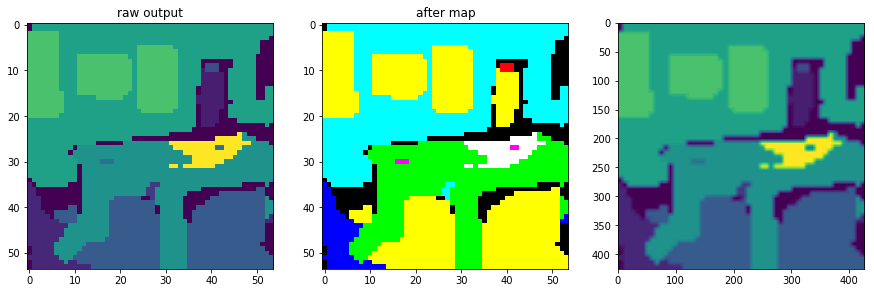

In [202]:
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import matplotlib.cm as cm
import matplotlib
%matplotlib inline 
#将图表显示在页面
plt.rcParams['figure.figsize'] = (15.0, 15.0)

# obtain the output from the last fcn layer
net.forward()
output =net.blobs['local_global_conv'].data[...] #raw output shape is (1,38,54,54)
print 'raw output shape is ' + str(np.shape(output))
output = np.transpose(output, [2,3,1,0])
output = output.squeeze()
print 'raw output after squeeze: ',np.shape(output)
output = np.argmax(output, axis=2) 
print ' output shape after argmax ',np.shape(output)

#取的是某一个通道，不能处理三个通道的问题
plt.subplot(1,3,1)
plt.imshow(output)
plt.title('raw output')
#plt.imsave('output.png',output)
output_raw=myimagesc(output,mapping)
plt.subplot(1,3,2)
plt.imshow(output_raw)
plt.title('after map')
print 'output after mapping:',np.shape(output_raw)
# Resize the output to the same resolution of image using simpel bilinear interpolation
output = scipy.misc.imresize(output, (426,426), interp='bilinear',mode='F')
#print 'output: ',output
output = output.astype("int8")
#output=np.abs(output)
plt.subplot(1,3,3)
plt.imshow(output)
print 'after interplotion:',np.shape(output)
print np.max(output)
output_before = myimagesc(output, mapping)

gt:
[[20 20 20 ..., 20 20 20]
 [20 20 20 ..., 20 20 20]
 [20 20 20 ..., 20 20 20]
 ..., 
 [10 10 10 ..., 10 10 10]
 [10 10 10 ..., 10 10 10]
 [10 10 10 ..., 10 10 10]]
0
234
(426, 426)
(426, 426, 3)


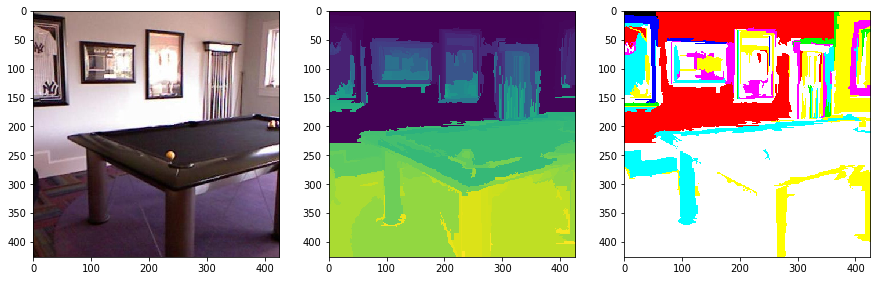

In [203]:
# For visulization purpose, here we use superpixel to smooth our predicted results from our pipeline
from skimage.segmentation import felzenszwalb
original_image = caffe.io.load_image(image_name)
# original_gt = caffe.io.load_image(gt_name,color=False)
original_gt=plt.imread(gt_name,0)
print 'gt:\n',original_gt
#img = img_middle_crop(original_image)
# here we use the default k=500, sigma=0.5, min=50, you can choose different hyperparameters for visulization
segments = felzenszwalb(original_image, scale=200, sigma=0.5, min_size=50) #segments单通道值,400+
# segments = felzenszwalb(img,scale=500, sigma=0.5,min_size=50) #segments单通道值,130
# segments = felzenszwalb(img,scale=500, sigma=0.2,min_size=60) #segments单通道值,
print np.min(segments)
print np.max(segments)
print np.shape(segments) 
plt.subplot(1,3,1)
img_for_show=np.squeeze(original_image)
plt.imshow(img_for_show)
plt.subplot(1,3,2)    
plt.imshow(segments)
segments1 = myimagesc(segments, mapping)
plt.subplot(1,3,3)
plt.imshow(segments1)
print np.shape(segments1)

In [204]:
min_label = np.min(segments)
max_label = np.max(segments)
print 'max_label(segment):',max_label
print 'min_label(segment):',min_label
segments_reshape = np.reshape(segments, (segments.shape[0]*segments.shape[1]))
print np.shape(segments_reshape)
output_reshape = np.reshape(output, (output.shape[0]*output.shape[1]))
print np.shape(output_reshape)                                                     
print np.max(output_reshape)
print np.min(output_reshape)
for i in xrange(min_label, max_label):
    inds = np.where(segments_reshape==i)[0]
    #print inds
    if inds.shape[0] != 0:
        select_label = output_reshape[inds]
        tmp_label = np.argmax(np.bincount(select_label))
        segments_reshape[inds] = tmp_label
output_2 = np.reshape(segments_reshape,(segments.shape[0], segments.shape[1]))
output_after = myimagesc(output_2, mapping)

max_label(segment): 234
min_label(segment): 0
(181476,)
(181476,)
35
0


(426, 426, 3)
gt:
[[20 20 20 ..., 20 20 20]
 [20 20 20 ..., 20 20 20]
 [20 20 20 ..., 20 20 20]
 ..., 
 [10 10 10 ..., 10 10 10]
 [10 10 10 ..., 10 10 10]
 [10 10 10 ..., 10 10 10]]
output:
[[ 0  0  0 ..., 20 20 20]
 [ 0  0  0 ..., 20 20 20]
 [ 0  0  0 ..., 20 20 20]
 ..., 
 [ 0  0  0 ..., 10 10 10]
 [ 0  0  0 ..., 10 10 10]
 [ 0  0  0 ..., 10 10 10]]


Text(0.5,1,u'Scene labeling after smooth')

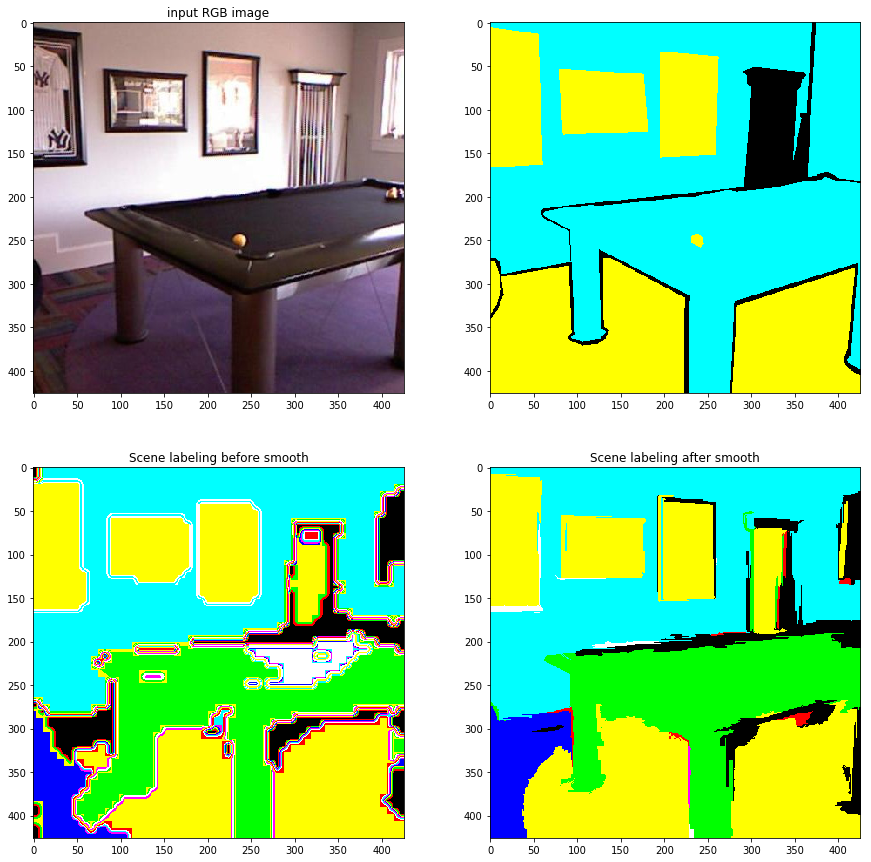

In [206]:
plt.subplot(2,2,1)
ol=np.squeeze(original_image)
#origin=img_middle_crop(ol)
# origin=image_resize(ol)
print np.shape(ol)
origin=np.squeeze(ol)

plt.imshow(ol)
#plt.imshow(np.squeeze(img_middle_crop(image_name)))
plt.title("input RGB image")

plt.subplot(2,2,2)
#original_gt=np.squeeze(original_gt)*255
print 'gt:\n',original_gt
original_gt=myimagesc(original_gt,mapping)
plt.imshow(original_gt)
print 'output:\n',output
#plt.title("Ground-truth scene labeling")

plt.subplot(2,2,3)
plt.imshow(output_before, vmin=0, vmax=255)
plt.title("Scene labeling before smooth")

plt.subplot(2,2,4)
plt.imshow(output_after)
plt.title("Scene labeling after smooth")